In [12]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [13]:
# more dependencies!!!
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
# putting together the engine
engine = create_engine("sqlite:///C:/Users/willj/GitLab/02-Homework/10-Advanced-Data-Storage-and-Retrieval/02-Case-Assignment/Resources/hawaii.sqlite")
conn = engine.connect()

In [38]:
#database
Bass = automap_base()
#tables
Bass.prepare(engine, reflect=True)

In [39]:
#view reflected table names
Bass.classes.keys()

['measurement', 'station']

In [40]:
#save each table
prcpMeasurement = Bass.classes.measurement
ActiveStation = Bass.classes.station

In [41]:
#create session 
engsession = Session(engine)

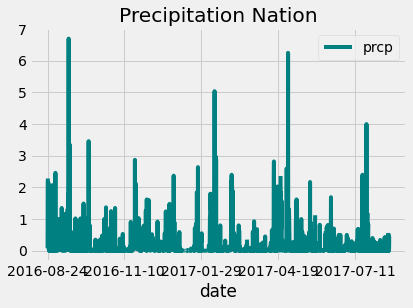

In [80]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

latest = (session.query(prcpMeasurement.date)
                     .order_by(prcpMeasurement.date.desc())
                     .first())
latest = list(np.ravel(latest))[0]
latest = dt.datetime.strptime(latest, '%Y-%m-%d')
Year = int(dt.datetime.strftime(latest, '%Y'))
Month = int(dt.datetime.strftime(latest, '%m'))
Day = int(dt.datetime.strftime(latest, '%d'))
yearprochaine = dt.date(Year, Month, Day) - dt.timedelta(days=365)
rain = (session.query(prcpMeasurement.date, prcpMeasurement.prcp)
                  .filter(prcpMeasurement.date > yearprochaine)
                  .order_by(prcpMeasurement.date)
                  .all())
Tabler = pd.DataFrame(rain)
Tabler = Tabler.set_index('date')
Tabler = Tabler.sort_index(ascending=True)
Tabler.plot(title="Precipitation Nation",color="teal")

In [45]:
# Use Pandas to calculate the summary statistics for the precipitation data
Tabler.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [46]:
# Design a query to show how many stations are available in this dataset?
stationsct = engsession.query(ActiveStation).count()
print(f"Station Count: {stationsct}")

Station Count: 9


In [47]:
stationcts = (session.query(prcpMeasurement.station, func.count(prcpMeasurement.station))
                        .group_by(prcpMeasurement.station)
                        .order_by(func.count(prcpMeasurement.station).desc())
                        .all())
stationcts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_id = stationcts[0][0]
station_nom = (engsession.query(ActiveStation.name)
                      .filter_by(station = station_id))
station_nom = station_nom[0][0]
print(f"The most active station is {station_id}: {station_nom}.")

The most active station is USC00519281: WAIHEE 837.5, HI US.


In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
dropitlow = (engsession.query(prcpMeasurement.tobs)
                     .filter(prcpMeasurement.station == station_id)
                     .order_by(prcpMeasurement.tobs.asc())
                     .first())
dropitlow = dropitlow[0]
print(f"The lowest temperature recorded there is {dropitlow} degrees Farenheit.")
raisetheroof = (engsession.query(prcpMeasurement.tobs)
                      .filter(prcpMeasurement.station == station_id)
                      .order_by(prcpMeasurement.tobs.desc())
                      .first())
raisetheroof = raisetheroof[0]
print(f"The highest temperature recorded there is {raisetheroof} degrees Farenheit.")
averaget = (engsession.query(func.avg(prcpMeasurement.tobs))
                  .filter(prcpMeasurement.station == station_id))
averaget = '{0:.3}'.format(averaget[0][0])
print(f"The average temperature recorded there is {averaget} degrees Farenheit.")

The lowest temperature recorded there is 54.0 degrees Farenheit.
The highest temperature recorded there is 85.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


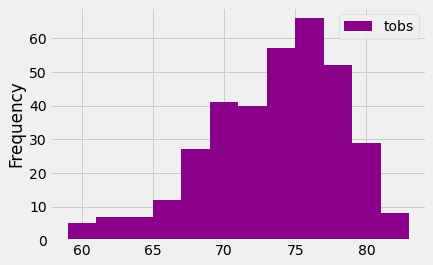

In [82]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
rawtemp = (session.query(prcpMeasurement.date, prcpMeasurement.tobs)
                   .filter(prcpMeasurement.date > yearprochaine)
                   .filter(prcpMeasurement.station == station_id)
                   .order_by(prcpMeasurement.date)
                   .all())
Tablet = pd.DataFrame(rawtemp)
Tablet = Tablet.set_index('date')
Tablet = Tablet.sort_index(ascending=True)
Tablet.plot(kind='hist', bins=12, color='darkmagenta')

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return engsession.query(func.min(prcpMeasurement.tobs), func.avg(prcpMeasurement.tobs), func.max(prcpMeasurement.tobs)).\
        filter(prcpMeasurement.date >= start_date).filter(prcpMeasurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = '2012-02-28 to \n 2012-03-05'
tripbegin = '2012-02-28'
tripfinito = '2012-03-15'
triptps = calc_temps(tripbegin, tripfinito)
triptps

[(61.0, 69.07936507936508, 75.0)]

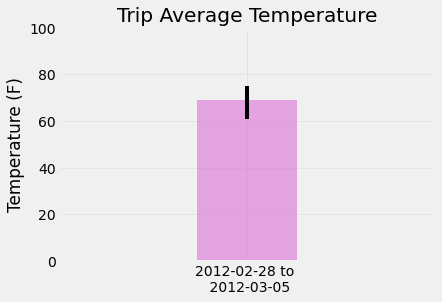

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lowertript = triptps[0][0]
avgtript = triptps[0][1]
uppertript = triptps[0][2]
minmiss = avgtript - lowertript
maxmiss = uppertript - avgtript
errorBars = np.array([[minmiss], [maxmiss]])
plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orchid', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Average Temperature')
plt.ylabel('Temperature (F)')
plt.grid(alpha=.3)

In [66]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([ActiveStation.station, 
        ActiveStation.name, 
        func.sum(prcpMeasurement.prcp), 
        ActiveStation.latitude, 
        ActiveStation.longitude, 
        ActiveStation.elevation
       ])
stationprcp = (engsession.query(*sel)
                   .filter(ActiveStation.station == prcpMeasurement.station)
                   .filter(prcpMeasurement.date >= tripbegin)
                   .filter(prcpMeasurement.date <= tripfinito)
                   .group_by(ActiveStation.station)
                   .order_by(func.sum(prcpMeasurement.prcp).desc())
                   .all())
stationtable = pd.DataFrame(np.array(stationprcp))
stationtable = stationtable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationtable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",23.43,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",21.18,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",16.320000000000004,21.4234,-157.8015,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",15.440000000000003,21.33556,-157.71139,19.5
4,USC00519397,"WAIKIKI 717.2, HI US",7.8999999999999995,21.2716,-157.8168,3.0
5,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",4.69,21.3152,-157.9992,0.9
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",4.37,21.5213,-157.8374,7.0
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",3.8400000000000003,21.4992,-158.0111,306.6
8,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


In [67]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    sel = [func.min(prcpMeasurement.tobs), func.avg(prcpMeasurement.tobs), func.max(prcpMeasurement.tobs)]
    return engsession.query(*sel).filter(func.strftime("%m-%d", prcpMeasurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [76]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
start = "2012-12-21"
end = "2012-12-31"
startn = int(start[-2:])
endn = int(end[-2:])
tripdur = endn - startn + 1
start = dt.datetime.strptime(start, '%Y-%m-%d')
datel = [dt.datetime.strftime(start + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripdur)]
trip_normals = [daily_normals(date) for date in datel]
trip_normals

[[(67.0, 72.13953488372093, 78.0)],
 [(67.0, 71.1304347826087, 77.0)],
 [(61.0, 70.34693877551021, 78.0)],
 [(62.0, 70.0625, 78.0)],
 [(60.0, 71.75, 79.0)],
 [(63.0, 71.44680851063829, 77.0)],
 [(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)],
 [(56.0, 68.27906976744185, 77.0)]]

In [77]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals = [np.array(normal[0]) for normal in trip_normals]
normals = pd.DataFrame(tripNormals)
normals["Date"] = datel
normals = normals.set_index("Date")
normals = normals.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
normals

,Low Temp,Avg Temp,High Temp
Date,,,
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0
12-29,57.0,70.291667,78.0


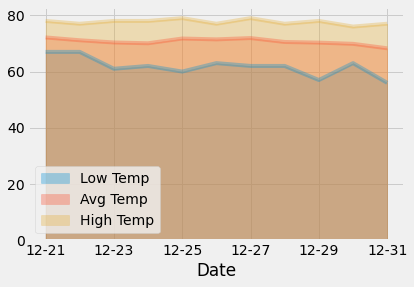

In [78]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.333)